<a href="https://colab.research.google.com/github/stash95/stepik_ML_project/blob/main/ML_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основы машинного обучения



## Где мы сейчас?

**Цели на буткемп:**

* провести разведочный анализ данных

* ***построить и проинтерпретировать ML-модель***

* обернуть ее в интерактивный веб-сервис

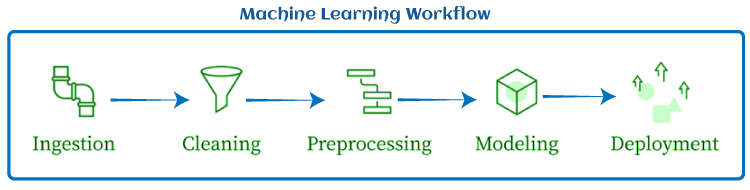

**Цели на сегодня:**

* разобраться в построенной модели машинного обучения

* научиться интерпретировать результат и прогноз модели

* понять, как можно влиять на прогнозы модели (выявлять больше не сдавших экзамен)

* научиться работать с категориальными признаками, у которых больше двух значений

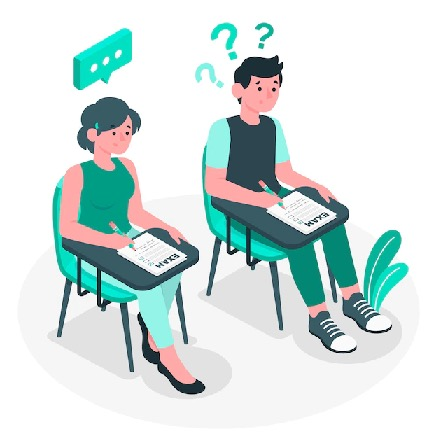

## Импорт библиотек и загрузка данных

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/stepik_from_idea_to_mvp/main/datasets/students_clean.csv")

## Описание данных

* gender - пол студента
* parental level of education - уровень образования родителей
* lunch - вид обеда студента
* class group - в какой группе обучался студент
* test preparation course - проходил ли студент курс для подготовки к экзаменам
* math score - балл за экзамен по математике
* reading score - балл за экзамен по чтению
* writing score (target) - балл за экзамен по письму, целевая переменная
* writing fail - бинарная переменная, равна 1 в случае, если студент не сдал экзамен (набрал менее 50 баллов за него), и 0 иначе

In [ ]:
df.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,class_group,writing fail
0,female,NaN,1,0,72.0,72.0,74,group B,0
1,female,some college,1,1,69.0,90.0,88,group C,0
2,female,master's degree,1,0,90.0,95.0,93,group B,0
3,male,associate's degree,0,0,47.0,57.0,44,group A,1
4,male,some college,1,0,76.0,78.0,75,group C,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   parental level of education  924 non-null    object 
 2   lunch                        1000 non-null   int64  
 3   test preparation course      1000 non-null   int64  
 4   math score                   1000 non-null   float64
 5   reading score                1000 non-null   float64
 6   writing score                1000 non-null   int64  
 7   class_group                  1000 non-null   object 
 8   writing fail                 1000 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 70.4+ KB


In [ ]:
df['parental level of education'].fillna('unknown', inplace=True)

## Машинное обучение. Предсказание успешной сдачи экзамена по `writing`

**Цель:** попробуем по характеристикам студентов предсказать, сдаст каждый из них экзамен по `writing` или нет.

Схема машинного обучения:

* есть обучающие данные (с известными ответами) - на них модель учится находить зависимость ответов от признаков объектов

* есть тестовые данные (с неизвестными для модели ответами) - на них мы проверяем качество обученной модели

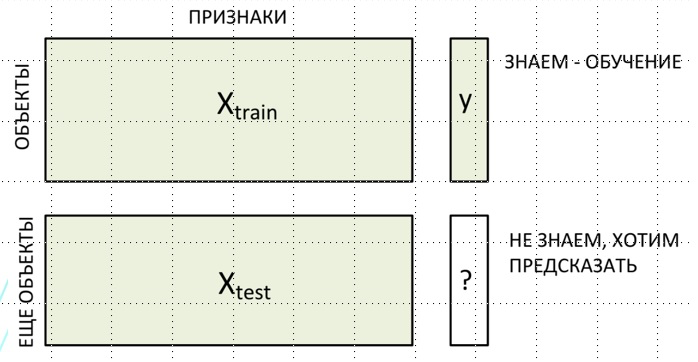

Так как мы предсказываем успех по `writing`, то удалим столбцы `writing score` и `writing success` из матрицы объект-признак.


In [ ]:
X = df.drop(['writing score', 'writing fail'], axis=1)

y = df['writing fail'] # целевая переменная (target)

In [ ]:
X.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,class_group
0,female,unknown,1,0,72.0,72.0,group B
1,female,some college,1,1,69.0,90.0,group C
2,female,master's degree,1,0,90.0,95.0,group B
3,male,associate's degree,0,0,47.0,57.0,group A
4,male,some college,1,0,76.0,78.0,group C


Чтобы применять классические модели машинного обучения, необходимо перевести категориальные (не являющиеся числами и не ведущие себя как числа) признаки в числовые.

На прошлом вебинаре мы перевели в числа 0 и 1 два бинарных признака: `lunch` и `test preparation course`.

Мы уже обучали модель на всех числовых признаках. Повторим этот шаг.


In [ ]:
X.drop(['gender', 'parental level of education', 'class_group'], axis=1, inplace=True)

In [ ]:
X.head()

,lunch,test preparation course,math score,reading score
0,1,0,72.0,72.0
1,1,1,69.0,90.0
2,1,0,90.0,95.0
3,0,0,47.0,57.0
4,1,0,76.0,78.0


Разобъем данные на тренировочную и тестовую части

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape

((750, 4), (250, 4))

Для решения нашей задачи будем использовать линейный классификатор под названием **логистическая регрессия**.

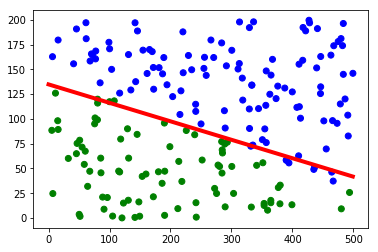

**Логистическая регрессия** - это линейный классификатор, прогноз которого является суммой признаков объектов с некоторыми коэффициентами (весами).

Когда модель предсказывает класс, она делает это по формуле
$$a(x) = sign(w_0 + w_1x_1 + w_2x_2 + ...),$$
то есть умножает признаки объекта $x_1,x_2,...$ на некоторые веса $w_0,w_1,w_2,...$

Например, если
* $x_1$ - `math score`
* $x_2$ - `lunch`,
то обученная модель может иметь вид
$$a(x) = sign(-12 + 1.2\cdot x_1 + 10\cdot x_2)$$

Веса модели подбираются автоматически так, чтобы модель как можно меньше ошибалась.

**Что такое обучение модели?**

Обучение модели - это подбор оптимальных весов модели ($w_0, w_1,...$) таким образом, чтобы модель на тренировочных данных давала наименьшую ошибку.

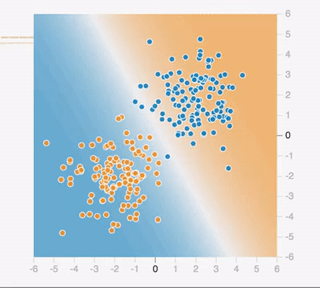

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train, y_train)

pred = model.predict(X_test)

In [ ]:
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred)

array([[213,   4],
       [  6,  27]])

### Оценка качества модели

Для оценки качества моделей классификации используются различные функции (метрики):

* accuracy
* precision
* recall
* f1-score
* ROC-AUC
* PR-AUC
и другие

**Accuracy** - это доля правильных ответов модели, самая понятная метрика. Однако не всегда ее разумно применять.

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred)

0.96

In [ ]:
y_test.value_counts()

0    217
1     33
Name: writing fail, dtype: int64

In [ ]:
# 217/(217+33)

Иногда цель - выявить объекты определенного класса. В нашей задаче нам интересно найти как можно больше студентов, кто не сдаст экзамен (класс 1), чтобы еще до экзамена можно было на них повлиять.

Доля найденных несдавших среди всех несдавших - это метрика под названием **полнота (recall)**.

In [ ]:
from sklearn.metrics import recall_score

recall_score(y_test, pred) # 27/33

0.8181818181818182

Парная к полноте метрика - точность (precision). Она показывает долю правильных ответов модели среди тех объектов, которые модель отнесла к положительному классу.

В нашем случае precision менее важна, чем recall, так как если мы скажем, что студент не сдаст экзамен и пообщаемся с ним, а он сдаст - хуже не будет. Но и лишний раз тревожить людей не стоит, поэтому

*обычно оптимизируют целевую метрику (в нашем случае recall) при условии, что парная метрика не слишком маленькая.*

In [ ]:
from sklearn.metrics import precision_score

precision_score(y_test, pred) # 27/31

0.8709677419354839

### Как повлиять на precison и recall?

**Логистическая регрессия** - это модель, которая умеет предсказывать не только классы, но и их *вероятности*!

Логистическая регрессия предсказывает вероятность положительного класса по формуле
$$a(x) = sigma(w_0 + w_1x_1 + w_2x_2 + ...),$$
где $sigma(t)=\frac{1}{1+e^{-t}}$ - сигмоида.

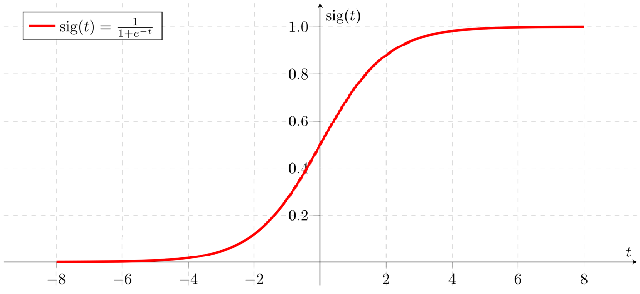

In [ ]:
probs = model.predict_proba(X_test)

probs[:5]

array([[9.99998652e-01, 1.34824892e-06],
       [9.99005555e-01, 9.94444521e-04],
       [9.99783598e-01, 2.16402014e-04],
       [9.99953878e-01, 4.61219847e-05],
       [9.99998781e-01, 1.21940289e-06]])

In [ ]:
probs[:,1][:5] # только вероятности несдачи

array([1.34824892e-06, 9.94444521e-04, 2.16402014e-04, 4.61219847e-05,
       1.21940289e-06])

Стандартный порог для перевода вероятности в классы $\theta=0.5$.

In [ ]:
classes = probs[:,1] > 0.5

classes[:5]

array([False, False, False, False, False])

Подбором порога можно влиять на точность и полноту. Поэкспериментируем.

In [ ]:
confusion_matrix(y_test, classes), recall_score(y_test, classes)

(array([[213,   4],
        [  6,  27]]),
 0.8181818181818182)

In [ ]:
classes = probs[:,1] > 0.8

confusion_matrix(y_test, classes), recall_score(y_test, classes)

(array([[216,   1],
        [  8,  25]]),
 0.7575757575757576)

In [ ]:
classes = probs[:,1] > 0.09

confusion_matrix(y_test, classes), recall_score(y_test, classes)

(array([[195,  22],
        [  0,  33]]),
 1.0)

**ВАЖНО!** Подбором порога мы не влияем на саму построенную модель (ее веса не меняются), мы влияем на итоговые интересующие нас метрики.

In [ ]:
model.coef_

array([[ 0.04442726, -1.30143598, -0.0065041 , -0.38515394]])

### Масштабирование признаков

Для обучения и более простой интерпретации многих моделей машинного обучения (для линейных моделей - обязательно) необходимо масштабировать признаки.

Масштабировать признаки означает привести их значения к одинаковым диапазонам.

In [ ]:
X_train.head()

,lunch,test preparation course,math score,reading score
82,0,1,50.0,47.0
991,1,1,65.0,82.0
789,0,0,52.0,65.0
894,1,0,59.0,62.0
398,1,0,74.0,63.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()
ss.fit(X_train) # вычислить min, max по каждому столбцу

X_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

X_train.head()

,lunch,test preparation course,math score,reading score
0,0.0,1.0,0.50,0.302632
1,1.0,1.0,0.65,0.763158
2,0.0,0.0,0.52,0.539474
3,1.0,0.0,0.59,0.500000
4,1.0,0.0,0.74,0.513158


### Оценка важности признаков

In [ ]:
model = LogisticRegression()

model.fit(X_train, y_train)

pred = model.predict(X_test)

Веса модели

In [ ]:
model.coef_, model.intercept_

(array([[-0.14093513, -0.83363119, -2.49657151, -7.20364806]]),
 array([3.23799995]))

In [ ]:
importances = pd.DataFrame({'weights': model.coef_[0], 'features': X_train.columns}).sort_values(by='weights')
importances.head()

,weights,features
3,-7.203648,reading score
2,-2.496572,math score
1,-0.833631,test preparation course
0,-0.140935,lunch


### Кодирование категориальных признаков

Если категориальный признак имеет больше двух категорий, то в общем случае его нельзя закодировать подряд идущими числами - так как при такой кодировке числа нельзя сравнивать между собой.

Стандартный подход - One Hot Encoding / get_dummies.

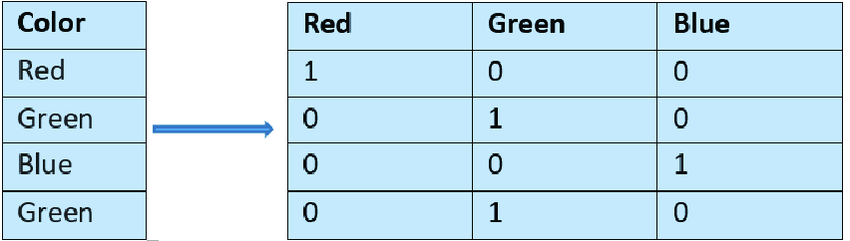

Так как мы будем кодировать категориальные признаки, то и обучать модель придется заново - на расширенном наборе данных.

In [ ]:
X = df.drop(['writing score', 'writing fail'], axis=1)

y = df['writing fail']

In [ ]:
X.dtypes

gender                          object
parental level of education     object
lunch                            int64
test preparation course          int64
math score                     float64
reading score                  float64
class_group                     object
dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Предобработаем признаки:

* закодируем категориальные признаки
* масштабируем числовые признаки

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['gender', 'parental level of education', 'class_group']
numeric_features = [col for col in X_train.columns if col not in categorical]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown="ignore"), categorical),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

In [ ]:
X_train_transformed

array([[1.        , 0.        , 0.        , ..., 1.        , 0.5       ,
        0.30263158],
       [0.        , 0.        , 0.        , ..., 1.        , 0.65      ,
        0.76315789],
       [0.        , 0.        , 0.        , ..., 0.        , 0.52      ,
        0.53947368],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.53      ,
        0.5       ],
       [1.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.31578947],
       [0.        , 0.        , 0.        , ..., 0.        , 0.85      ,
        0.88157895]])

Добавим названия колонок (опционально, но полезно)

In [ ]:
lst = list(column_transformer.transformers_[0][1].get_feature_names_out())
lst.extend(numeric_features)

X_train_transformed = pd.DataFrame(X_train_transformed, columns=lst)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=lst)

X_train_transformed.head()

,gender_male,gender_unknown,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,parental level of education_unknown,class_group_group B,class_group_group C,class_group_group D,class_group_group E,lunch,test preparation course,math score,reading score
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.50,0.302632
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.65,0.763158
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.52,0.539474
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.59,0.500000
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.74,0.513158


In [ ]:
model = LogisticRegression()

model.fit(X_train_transformed, y_train)

pred = model.predict_proba(X_test_transformed)[:,1]

In [ ]:
classes = pred > 0.5

confusion_matrix(y_test, classes), recall_score(y_test, classes)

(array([[216,   1],
        [ 10,  23]]),
 0.696969696969697)

In [ ]:
classes = pred > 0.22

confusion_matrix(y_test, classes), recall_score(y_test, classes)

(array([[199,  18],
        [  0,  33]]),
 1.0)

In [ ]:
importances = pd.DataFrame({'weights': model.coef_[0], 'features': X_train_transformed.columns}).sort_values(by='weights')
importances

,weights,features
15,-6.615178,reading score
14,-3.107649,math score
13,-0.973161,test preparation course
4,-0.877431,parental level of education_master's degree
10,-0.664758,class_group_group D
9,-0.460827,class_group_group C
12,-0.253158,lunch
11,-0.045996,class_group_group E
8,-0.010493,class_group_group B
2,0.190886,parental level of education_bachelor's degree


### Сохранение модели

In [ ]:
import pickle

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

#а так модель можно загрузить из файла:
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

# Курсы сообщества AI Education

**Интенсивы**

---
[Разведочный анализ данных](https://stepik.org/a/177213)

На интенсиве вы познакомитесь с основными и продвинутыми подходами анализа данных:
  * Научитесь исследовать данные при помощи современных библиотек (NumPy, Pandas, Polars, Matplotlib, Seaborn)
  * Обучите свою первую модель машинного обучения
  * Построите интерактивный дашборд при помощи инструмента ExplainerDashboard
  * Начнете использовать такие инструменты разработчика как Git и Docker


[Линейные модели и их презентация](https://stepik.org/a/177215)  

В курсе вы не только разберете теоретическую сторону предмета, но и узнаете как использовать модели на практике:
  * Будете оценивать качество моделей регрессии и классификации
  * Проходить все этапы задачи ML: от разведочного анализа до получения прогноза и его интерпретации
  * Cтроить интерактивные дашборды при помощи библиотеки Streamlit
  * Cоздавать веб-сервисы с использованием фреймворка FastApi


В каждом интенсиве по 9 вебинаров (4 по анализу данных / 4 по разработке / финальный с подведением итогов и защитой проектов по желанию).

**Курсы**

[Практический Machine Learning](https://stepik.org/a/125501)

  * Курс посвящен изучению всех основных задач и подходов в машинном обучении. Курс дает как теорию методов, так и обширную практику.
  * За 16 недель курса вы пройдете путь практически с нуля в машинном обучении до уверенного владения основными алгоритмами и подходами.

[Прикладные задачи машинного обучения](https://stepik.org/a/175967)

* В курсе подробно разобраны следующие темы:

  * построение рекомендательных систем
  * анализ временных рядов
  * продвинутые методы интерпретации ML-моделей
  * AutoML

* Курс находится в процессе наполнения, в нем будут появляться новые актуальные и прикладные в ML-темы.